In [1]:
import random
import ja_helpers as ja_helpers; from ja_helpers import *
import stat_helpers as stat_helpers; from stat_helpers import *

In [2]:
HOME_DIR = 'd:/larc_projects/job_analytics/'
DATA_DIR = HOME_DIR + 'data/clean/'; RES_DIR = HOME_DIR + 'results/'

In [3]:
df = pd.read_csv(DATA_DIR + 'uniq_doc_index.csv')
df.shape

(80464, 9)

In [4]:
n_topic=20; fname = DATA_DIR + 'doc_{}topic_distr.mtx'.format(n_topic)
with(open(fname, 'r')) as f:
    doc_topic_distr = mmread(f)

In [8]:
# df = df.set_index('index')
df.head()

,doc,job_id,title,n_skill,occur_skills,employer_id,employer_name,industry
index,,,,,,,,
72585,must have own customer base develop new and pr...,JOB-2015-0225927,Sales Executive,9,"freight,logistics,routing,sop,following up,pro...",198701829Z,"""K"" LINE LOGISTICS (SINGAPORE) PTE. LTD.",Transportation and Storage
72209,perform ar and ap functions preparation of aud...,JOB-2015-0196481,Accounts Executive,5,"administrative,audit,gst,reconciliation,cash f...",198701829Z,"""K"" LINE LOGISTICS (SINGAPORE) PTE. LTD.",Transportation and Storage
97747,1 special cargo related check special cargo ap...,JOB-2015-0242935,Executive,4,"cargo,offices,parties,prevention",199902703D,"""K"" LINE PTE LTD",Transportation and Storage
91456,job description manage and supervise local off...,JOB-2015-0190267,Operations Executive,8,"contracts,efficiency,inform,offices,parties,pa...",199902703D,"""K"" LINE PTE LTD",Transportation and Storage
88536,monthly maintainence and repair cost monitorin...,JOB-2015-0160717,Chief Engineer,4,"audit,container,cost reporting,technical support",199902703D,"""K"" LINE PTE LTD",Transportation and Storage


## Consistency of Job Posts

The consistency of job posts under the same job title let us know whether the title is a __specialized__ or __non-specialized__ job. For example Software Engineer vs. Manager....

### Across industries

Given a job title, we compute its consistency score for all job posts under the title. Thus the score is computed across industries.

For a job title with more than 100 posts, computing the pairwise similarity scores of job posts will be time consuming, as we need to compute at least 5000 scores. To speed up, we use sampling strategy, e.g., for such a job title, we just compute similarity scores for a sample of 100 posts (each with at least x skills, where x is the first quartile of n_skill). Thus, we first need to set seed for reproducible results later on.

In [15]:
random.seed(1234567)

In [30]:
def cScore_all_industry(job_title, df):

    sub_df = df[df['title'] == job_title]
    # rm posts with too few skills
    lb = sub_df['n_skill'].quantile(.25) 
    sub_df = sub_df[(sub_df['n_skill'] >= lb)]
    n_post = sub_df.shape[0]
    posts_of_title = sub_df.sample(n=100) if n_post > 100 else sub_df
        
    sample_size = posts_of_title.shape[0]
    print('Job title {}:'.format(job_title))
    print('\t use {} posts, each post with at least {} skills...'.format(sample_size, int(lb)))
    
    t0 = time(); 
    res = calScore(posts_of_title, doc_topic_distr)
    print('\t done after %.1fs' %(time() - t0))
    
    score = round(res['sim_score'].mean(), 3)
    # score = round(res['sim_score'].median(), 3)
    print('\t consistency score: {}'.format(score))
    return score
    #     return res

def cScoreByIndustry(job_title='Research Fellow', industry='Education', df=df):
    print('Job title: {}, Industry: {}'.format(job_title, industry))
    sub_df = df[(df['title'] == job_title) & (df['industry'] == industry)]
    n_post = sub_df.shape[0] 
    print('\t total # posts: {}'.format(n_post))
    if not sub_df.empty:
        # rm posts with too few skills
        lb = sub_df['n_skill'].quantile(.25) 
        sub_df = sub_df[(sub_df['n_skill'] >= lb)]
        n_post = sub_df.shape[0]
        posts_of_title = sub_df.sample(n=100) if n_post > 100 else sub_df

        sample_size = posts_of_title.shape[0]
        print('\t use {} posts, each post with at least {} skills...'.format(sample_size, int(lb)))

        t0 = time(); 
        res = calScore(posts_of_title, doc_topic_distr)
        print('\t done after %.1fs' %(time() - t0))

        score = round(res['sim_score'].mean(), 3)
        # score = round(res['sim_score'].median(), 3)
        print('\t consistency score: {}'.format(score))
        return score
        #     return res
    pass

def calScore4Row(r):
    job_title, industry = r['title'], r['industry']
    return cScoreByIndustry(job_title, industry)

def aggByJobTitle(df):
    by_job_title = df.groupby('title')
    agg_df = by_job_title.agg({'job_id': 'nunique', 'industry': 'nunique'})
    agg_df = agg_df.add_prefix('n_').reset_index()

    agg_df.rename(columns={'n_job_id': 'n_post'}, inplace=True)
    return agg_df.sort_values('n_post', ascending=False)

In [21]:
agg_df = aggByJobTitle(df)
agg_df['n_post'].describe().round(1)

count    4954.0
mean       16.2
std        51.7
min         1.0
25%         1.0
50%         4.0
75%        12.0
max      1184.0
Name: n_post, dtype: float64

In [22]:
agg_df = agg_df.query('n_post >= 5')
titles = agg_df['title']; len(titles)

2217

In [ ]:
agg_df['consistency_score'] = agg_df['title'].apply(cScore_all_industry, df=df)

In [358]:
agg_df.query('title == "Analyst"')

,title,n_industry,n_post,c_score_overall,c_score_by_industry,c_score_diff
202,Analyst,16,1283,0.799,0.876,0.077


Analyzing the result shows us that there are consistency scores that are unexpectedly high. In the above example, job title Analyst has a consistency score 0.799. What is the reason of this? To get to the root of this, we need to plot cluster distributions of job posts to check how similar they can be.

In [18]:
# Global settings for all cluster plots
abbv_clusters = ['FIN', 'HWR', 'SCI', 'PROD', 'CON', 'LEG', 'CUS', 'LOG', 'MKT', 'SWR', 'MAN', 'HOS', 'AUD', 'COM', 'HR']
x = range(1, 16); labels = abbv_clusters

In [19]:
def getPosts2Check(job_title, industry, n_pair=10):
    sub_df = df[(df['title'] == job_title) & (df['industry'] == industry)]
    # Drop duplicated posts due to reposting
    
    scores = calScore(sub_df, doc_topic_distr)
    scores = scores.query('sim_score < 1').sort_values('sim_score', ascending=False)

    k_pairs = scores.head(n_pair)
    
    ids2check = np.unique(list(k_pairs['job_id1']) + list(k_pairs['job_id2']))
    print('# posts to check: %d' %len(ids2check))

    posts2check = sub_df[sub_df['job_id'].isin(ids2check)]
    return posts2check.sort_values('employer_name')

#     return k_pairs

def plotClusterDists(posts, doc_topic_distr, figsize):
    n_post = posts.shape[0]
    fig, axarr = plt.subplots(n_post, sharex=True, figsize=figsize)

    for r in range(n_post):
        plt.subplot(n_post, 1, r+1)
        plotClusterDistAtRow(r, posts, doc_topic_distr)
        # Show ylabel at the middle
        if r==(n_post/2 - 1): 
            plt.ylabel('Probability', fontsize=24)

    ## Fine tune the fig    
    fig.subplots_adjust(hspace=.5)

    # Hide xticks on all subplots except the last one
    hide_xticks(fig)

    # Provide xtick labels only for the last subplot
    plt.xticks(x, labels, rotation=45)
    # Show xlabel only at the last subplot    
    plt.xlabel('Skill Clusters', fontsize=20)
    return fig

Computing pair similarity scores among 31 job posts,
each post is compared with subseq posts...
	 0 posts and counting...
	 10 posts and counting...
	 20 posts and counting...
Done after 0.6s
# posts to check: 9


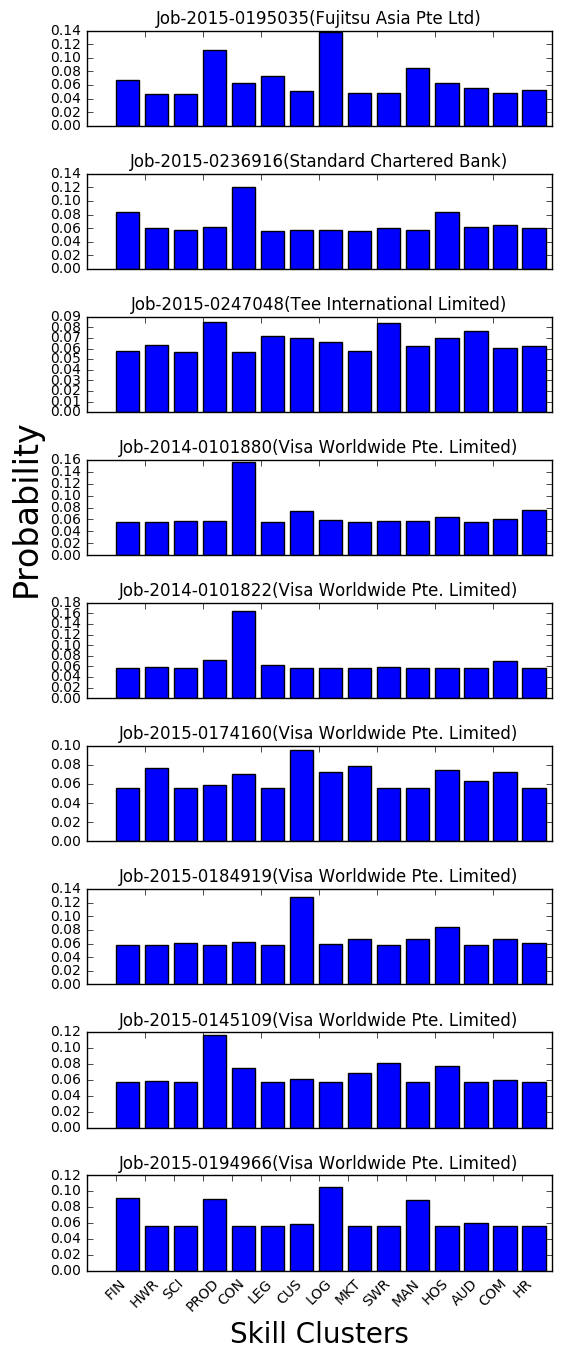

In [33]:
posts2check = getPosts2Check(job_title="Software Engineer", industry="Financial and Insurance Activities", n_pair=5)
fig = plotClusterDists(posts2check)
# plt.savefig(LDA_DIR + 'fig/se_in_fin.jpg')
plt.show(); plt.close()

From the plot, we can see obvious __duplications due to reposting jobs__. We should have created these plots from the beginning to detect the duplication earlier.

__Lesson learnt__: Anytime needed, e.g. when there are _sth not right_, plot things out to get a clear picture.

### Consistency scores after Duplication Filtering

In [38]:
reload(ja_helpers)
from ja_helpers import *

In [ ]:
filter_df = pd.read_csv(DATA_DIR + 'filter_doc_index.csv')
filter_df.set_index('index', inplace=True)

In [25]:
# Simply removing exact dups
print cScore_all_industry('Analyst', df)
cScoreByIndustry('Analyst', industry='Financial and Insurance Activities', df=df)

Job title Analyst:
	 use 100 posts, each post with at least 10 skills...
Computing pair similarity scores among 100 job posts,
each post is compared with subseq posts...
	 0 posts and counting...
	 10 posts and counting...
	 20 posts and counting...
	 30 posts and counting...
	 40 posts and counting...
	 50 posts and counting...
	 60 posts and counting...
	 70 posts and counting...
	 80 posts and counting...
	 90 posts and counting...
Done after 6.6s
	 done after 6.6s
	 consistency score: 0.957


0.957

In [32]:
# Filtering also similar posts
cScoreByIndustry('Analyst', industry='Financial and Insurance Activities', df=filter_df)

Job title: Analyst, Industry: Financial and Insurance Activities
	 total # posts: 525
	 use 100 posts, each post with at least 10 skills...
Computing pair similarity scores among 100 job posts,
each post is compared with subseq posts...
	 0 posts and counting...
	 10 posts and counting...
	 20 posts and counting...
	 30 posts and counting...
	 40 posts and counting...
	 50 posts and counting...
	 60 posts and counting...
	 70 posts and counting...
	 80 posts and counting...
	 90 posts and counting...
Done after 6.6s
	 done after 6.7s
	 consistency score: 0.957


0.957

In [360]:
t0 = time()
agg_df['consistency_score_2'] = agg_df['title'].apply(cScore_all_industry)
print('Done after %.1fs' %(time() - t0))

Job title Administrative Assistant:
	 use 100 posts, each post with at least 6 skills...
Computing pair similarity scores among 100 job posts,
each post is compared with subseq posts...
	 0 posts and counting...
	 10 posts and counting...
	 20 posts and counting...
	 30 posts and counting...
	 40 posts and counting...
	 50 posts and counting...
	 60 posts and counting...
	 70 posts and counting...
	 80 posts and counting...
	 90 posts and counting...
Done after 6.5s
	 done after 6.5s
	 consistency score: 0.987
Job title Analyst:
	 use 100 posts, each post with at least 10 skills...
Computing pair similarity scores among 100 job posts,
each post is compared with subseq posts...
	 0 posts and counting...
	 10 posts and counting...
	 20 posts and counting...
	 30 posts and counting...
	 40 posts and counting...
	 50 posts and counting...
	 60 posts and counting...
	 70 posts and counting...
	 80 posts and counting...
	 90 posts and counting...
Done after 6.8s
	 done after 6.8s
	 consisten

KeyboardInterrupt: 

In the first re-run, consistency score is still too high. There are still problems. Let us re-plot cluster distributions again to see if we really get rid of dups.

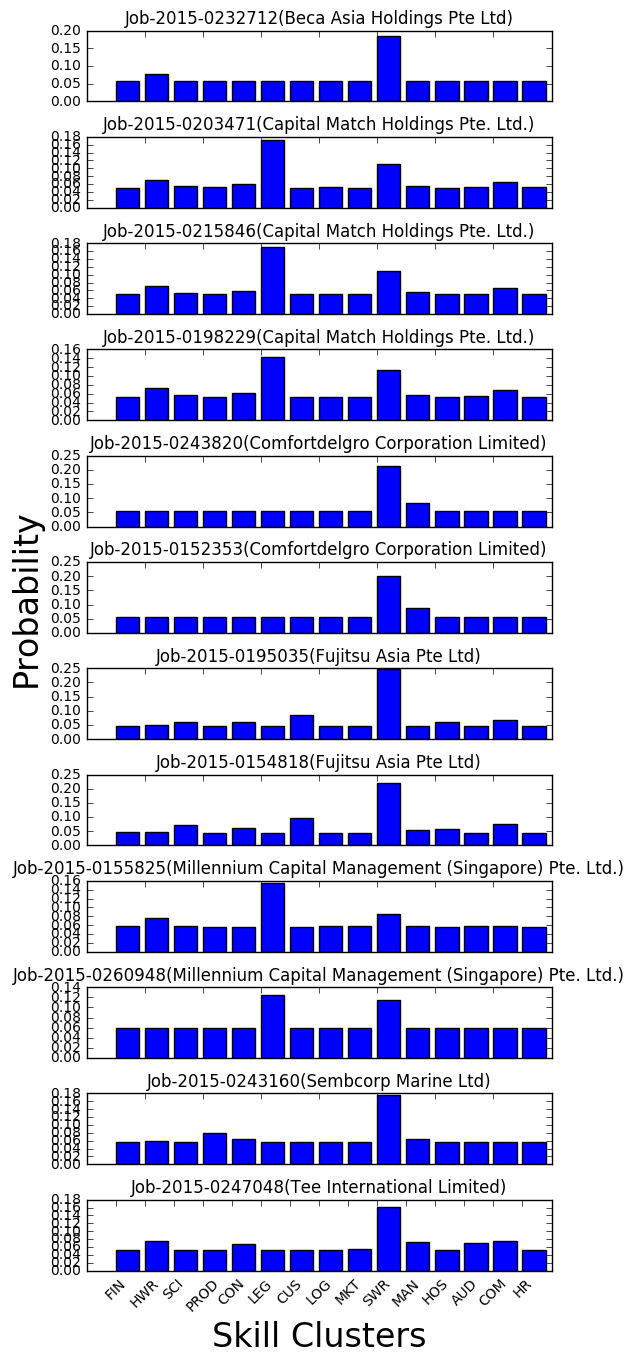

In [280]:
fig = plotClusterDists(posts2check)
# plt.savefig(LDA_DIR + 'fig/se_in_fin2.pdf')
plt.show(); plt.close()

__Duplications seem still exist!__ Let us examine further.

+ Sample posts for SE:

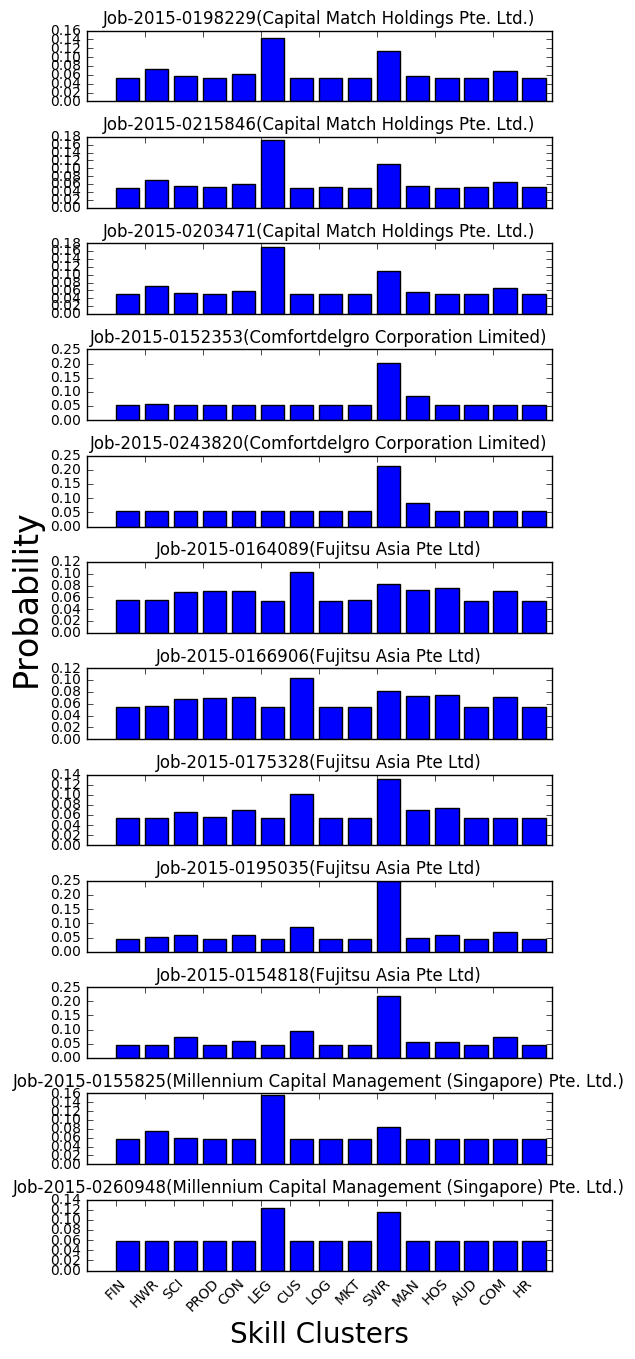

In [41]:
sample_employers = ["Capital Match Holdings Pte. Ltd.", "Comfortdelgro Corporation Limited", "Fujitsu Asia Pte Ltd", 
             "Millennium Capital Management (Singapore) Pte. Ltd."]

sample_employers = map(str.upper, sample_employers)
sample_se_posts = df[(df.employer_name.isin(sample_employers)) & (df.title == "Software Engineer")]
se_fig = plotClusterDists(sample_se_posts)

plt.show(); plt.close()

+ Sample posts for Administrative Assistant:

In [ ]:
posts = getPosts2Check(job_title="Administrative Assistant", industry="Financial and Insurance Activities", n_pair=5)

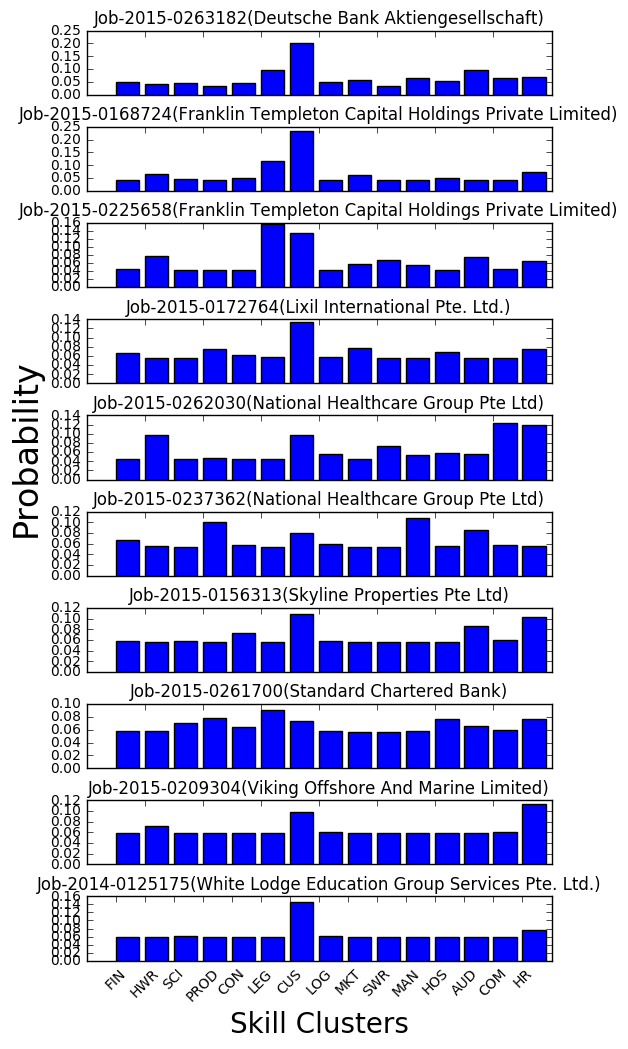

In [60]:
fig = plotClusterDists(posts, figsize=(6, 12))
# plt.savefig(LDA_DIR + 'fig/admin_in_fin.jpg')
plt.show(); plt.close()

In [61]:
# Manager
posts = getPosts2Check(job_title="Manager", industry="Financial and Insurance Activities", n_pair=5)

Computing pair similarity scores among 255 job posts,
each post is compared with subseq posts...
	 0 posts and counting...
	 10 posts and counting...
	 20 posts and counting...
	 30 posts and counting...
	 40 posts and counting...
	 50 posts and counting...
	 60 posts and counting...
	 70 posts and counting...
	 80 posts and counting...
	 90 posts and counting...
	 100 posts and counting...
	 110 posts and counting...
	 120 posts and counting...
	 130 posts and counting...
	 140 posts and counting...
	 150 posts and counting...
	 160 posts and counting...
	 170 posts and counting...
	 180 posts and counting...
	 190 posts and counting...
	 200 posts and counting...
	 210 posts and counting...
	 220 posts and counting...
	 230 posts and counting...
	 240 posts and counting...
	 250 posts and counting...
Done after 44.3s
# posts to check: 8


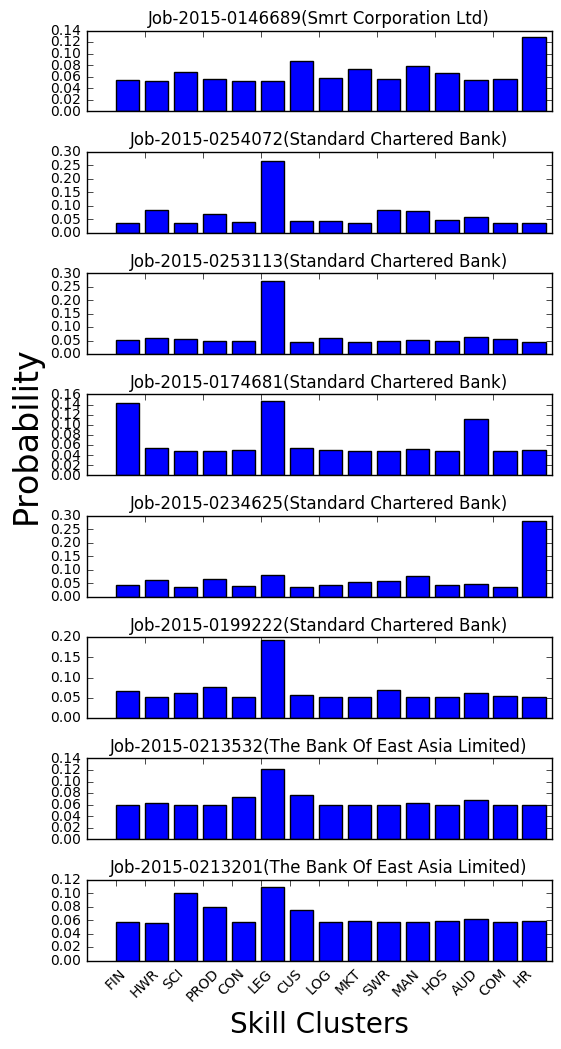

In [64]:
fig = plotClusterDists(posts, figsize=(6, 12))
plt.savefig(LDA_DIR + 'fig/man_in_fin.jpg')
plt.savefig(LDA_DIR + 'fig/man_in_fin.pdf')
plt.show(); plt.close()

In [24]:
agg_df = agg_df.sort_values('consistency_score', ascending=False)
agg_df.to_csv(JOB_PROF + 'c_score.csv', index=False)

### Consistency score by industry

In this part, we look at consistency scores of job titles within each industry, e.g., given a job title, we examine if its job posts __within a given industry__ are highly consistent or not. As we are looking at job posts in the same industry, we expect that they are more consistent than when the job posts are scattered across industry. Thus, the first intuition is that the __score within industry should be higher than the score across industries__.

In [9]:
by_job_and_industry = df.groupby(['title', 'industry'])
tmp = by_job_and_industry.agg({'job_id': 'nunique'})
tmp = tmp.add_prefix('n_').reset_index()

tmp.rename(columns={'n_job_id': 'n_post'}, inplace=True)
tmp = tmp.sort_values('n_post', ascending=False)
tmp.head()

,title,industry,n_post
1013,Analyst,Financial and Insurance Activities,730
1970,Associate,Financial and Insurance Activities,598
11418,Research Fellow,Education,578
553,Administrative Assistant,Administrative and Support Service Activities,501
11104,Recruitment Consultant,Administrative and Support Service Activities,387


In [10]:
tmp['n_post'].describe().round(1)

count    16541.0
mean         6.5
std         19.7
min          1.0
25%          1.0
50%          2.0
75%          5.0
max        730.0
Name: n_post, dtype: float64

In [11]:
industry_agg_df = tmp.query('n_post >= 5')
industry_agg_df['n_post'].describe().round(1)

count    4548.0
mean       19.0
std        34.5
min         5.0
25%         6.0
50%         9.0
75%        18.0
max       730.0
Name: n_post, dtype: float64

In [ ]:
# rf_in_edu = cScoreByIndustry(job_title='Research Fellow', industry='Education')
# rf_in_edu = rf_in_edu.sort_values('sim_score')
# rf_in_edu.head()

In [69]:
# calScore4Row(industry_agg_df.iloc[0])
t0 = time()
industry_agg_df['consistency_score'] = industry_agg_df.apply(calScore4Row, 1)
print('Done after %.1fs' %(time() - t0))

Job title: Site Supervisor, Industry: Other Service Activities
	 total # posts: 17
	 use 13 posts, each post with at least 11 skills...
	 done after 0.1s
	 consistency score: 1.0
Job title: Data Warehousing Consultant, Industry: Information and Communications
	 total # posts: 7
	 use 5 posts, each post with at least 15 skills...
	 done after 0.0s
	 consistency score: 1.0
Job title: Data Coordinator, Industry: Professional, Scientific and Technical Activities
	 total # posts: 5
	 use 5 posts, each post with at least 7 skills...
	 done after 0.0s
	 consistency score: 1.0
Job title: Instrument Electrical Engineer, Industry: Transportation and Storage
	 total # posts: 5
	 use 5 posts, each post with at least 13 skills...
	 done after 0.0s
	 consistency score: 1.0
Job title: Shop Manager, Industry: Accommodation and Food Service Activities
	 total # posts: 5
	 use 4 posts, each post with at least 14 skills...
	 done after 0.0s
	 consistency score: 1.0
Job title: Adviser, Service (Customer A

In [70]:
industry_agg_df = industry_agg_df.sort_values('consistency_score', ascending=False)
industry_agg_df.to_csv(JOB_PROF + 'c_score_by_industry.csv', index=False)

In [25]:
industries = industry_agg_df['industry'].unique()
industries

array(['Other Service Activities', 'Wholesale and Retail Trade',
       'Administrative and Support Service Activities',
       'Professional, Scientific and Technical Activities',
       'Transportation and Storage', 'Manufacturing',
       'Information and Communications',
       'Public Administration and Defence', 'Real Estate Activities',
       'Financial and Insurance Activities', 'Education',
       'Accommodation and Food Service Activities',
       'Electricity, Gas and Air-Conditioning Supply', 'Construction',
       'Arts, Entertainment and Recreation', 'Mining and Quarrying',
       'Unknown', 'Health and Social Services'], dtype=object)

#### Is within-industry score higher than across-industry score?

In [111]:
def avgIndustryScore(job_title):
    score = industry_agg_df.query('title == "{}"'.format(job_title))['consistency_score'].mean()
    return round(score, 3)

In [112]:
avgIndustryScore('Software Engineer')

0.912

In [113]:
%time agg_df['score_by_industry'] = agg_df['title'].apply(avgIndustryScore)

Wall time: 3.44 s


In [ ]:
agg_df.rename(columns={'consistency_score': 'c_score_overall', 'score_by_industry': 'c_score_by_industry'}, inplace=True)
agg_df['c_score_overall'] = map(lambda x:round(x,3), agg_df['c_score_overall'])

In [118]:
agg_df['c_score_diff'] = agg_df['c_score_by_industry'] - agg_df['c_score_overall']
agg_df.head()

,title,n_industry,n_post,c_score_overall,c_score_by_industry,c_score_diff
82,Administrative Assistant,18,1634,0.937,0.928,-0.009
202,Analyst,16,1283,0.799,0.876,0.077
623,Business Analyst,14,1009,0.862,0.903,0.041
2237,Manager,16,983,0.757,0.900,0.143
437,Associate,11,845,0.790,0.869,0.079


In [124]:
# agg_df['c_score_by_industry'].notnull()
res = agg_df[agg_df['c_score_by_industry'].notnull() ]

(1849, 6)

In [125]:
res['c_score_diff'].describe().round(3)

count    1849.000
mean        0.033
std         0.031
min        -0.022
25%         0.007
50%         0.028
75%         0.051
max         0.221
Name: c_score_diff, dtype: float64

In [126]:
res = res.sort_values('c_score_diff', ascending=False)
res.head()

,title,n_industry,n_post,c_score_overall,c_score_by_industry,c_score_diff
113,Advertising Account Executive,3,14,0.753,0.974,0.221
1066,Corporate Communications Manager,13,49,0.774,0.946,0.172
20,Account Manager,11,424,0.731,0.893,0.162
3156,Research Fellow,5,688,0.775,0.932,0.157
1962,Information Technology Manager,15,249,0.772,0.917,0.145


In [129]:
# res.n_post.describe().round(1)
res.query('n_post >= 200')

,title,n_industry,n_post,c_score_overall,c_score_by_industry,c_score_diff
20,Account Manager,11,424,0.731,0.893,0.162
3156,Research Fellow,5,688,0.775,0.932,0.157
1962,Information Technology Manager,15,249,0.772,0.917,0.145
2237,Manager,16,983,0.757,0.900,0.143
1410,Electrical Engineer (General),14,280,0.777,0.908,0.131
3154,Research Engineer,7,202,0.814,0.939,0.125
1941,Information System Engineer,12,319,0.782,0.894,0.112
2345,Marketing Manager,13,343,0.803,0.911,0.108
1749,General Manager,15,202,0.841,0.949,0.108
1643,Finance Manager,16,397,0.822,0.925,0.103


#### Consistency Scores of Tech Jobs 

In [132]:
it_res = industry_agg_df.query('industry == "Information and Communications"').query('n_post >= 10')
it_res = it_res.sort_values('consistency_score', ascending=False)

In [133]:
it_res['n_post'].describe().round(1)

count    270.0
mean      38.5
std       51.0
min       10.0
25%       13.0
50%       20.0
75%       35.8
max      361.0
Name: n_post, dtype: float64

In [139]:
# SE consistency_score by industry
se_by_industry = industry_agg_df.query('title == "Software Engineer"')
round(se_by_industry.consistency_score.mean(), 3)

0.912

In [140]:
# SE consistency_score across industry
cScore_all_industry('Software Engineer')

Job title Software Engineer:
	 use 100 posts, each post with at least 7 skills...
	 done after 6.5s
	 consistency score: 0.868


0.868

In [141]:
se_by_industry

,title,industry,n_post,consistency_score
15069,Software Engineer,Transportation and Storage,5,0.987
15062,Software Engineer,Education,7,0.970
15063,Software Engineer,Financial and Insurance Activities,48,0.952
15060,Software Engineer,Administrative and Support Service Activities,160,0.919
15070,Software Engineer,Wholesale and Retail Trade,62,0.886
15067,Software Engineer,"Professional, Scientific and Technical Activities",85,0.878
15064,Software Engineer,Information and Communications,334,0.861
15065,Software Engineer,Manufacturing,77,0.847


In [136]:
round(it_res['consistency_score'].mean(), 3)

0.919

#### Consistency Scores of Jobs in Education

In [137]:
edu_res = industry_agg_df.query('industry == "Education"').query('n_post >= 10')
round(edu_res['consistency_score'].mean(), 3)
# edu_res['n_post'].describe().round(1)

0.934

#### Consistency Scores of Jobs in Finance

In [138]:
fin_res = industry_agg_df.query('industry == "Financial and Insurance Activities"')
round(fin_res['consistency_score'].mean(), 3)

0.938

#### Consistency Scores of Jobs in Others

In [56]:
other_res = industry_agg_df.query('industry == "Other Service Activities"')
other_res['n_post'].describe().round(1)
other_res.query('n_post >= 10')['consistency_score'].describe().round(3)

count    77.0
mean     10.6
std       7.3
min       5.0
25%       6.0
50%       8.0
75%      12.0
max      55.0
Name: n_post, dtype: float64

#### Specific jobs

In [64]:
agg_df = agg_df.sort_values('n_post', ascending=False)
agg_df.head()

,title,n_industry,n_post,consistency_score
82,Administrative Assistant,18,1634,0.937367
202,Analyst,16,1283,0.798897
623,Business Analyst,14,1009,0.862132
2237,Manager,16,983,0.756782
437,Associate,11,845,0.790210


In [142]:
agg_df.query('title == "Administrative Assistant"')

,title,n_industry,n_post,c_score_overall,c_score_by_industry,c_score_diff
82,Administrative Assistant,18,1634,0.937,0.928,-0.009


+ Administrative Assistant:

In [65]:
admin_assist = industry_agg_df.query('title == "Administrative Assistant"')
admin_assist

,title,industry,n_post,consistency_score
562,Administrative Assistant,Mining and Quarrying,5,0.983
555,Administrative Assistant,"Arts, Entertainment and Recreation",5,0.970
566,Administrative Assistant,Real Estate Activities,24,0.970
563,Administrative Assistant,Other Service Activities,21,0.967
568,Administrative Assistant,Unknown,7,0.962
556,Administrative Assistant,Construction,94,0.953
561,Administrative Assistant,Manufacturing,133,0.941
552,Administrative Assistant,Accommodation and Food Service Activities,25,0.937
567,Administrative Assistant,Transportation and Storage,48,0.933
559,Administrative Assistant,Health and Social Services,58,0.924


+ Analyst:

In [62]:
analyst_by_industry = industry_agg_df.query('title == "Analyst"')
analyst_by_industry

,title,industry,n_post,consistency_score
1017,Analyst,Other Service Activities,9,0.974
1020,Analyst,Real Estate Activities,22,0.913
1021,Analyst,Transportation and Storage,14,0.885
1022,Analyst,Wholesale and Retail Trade,42,0.884
1015,Analyst,Information and Communications,133,0.866
1016,Analyst,Manufacturing,26,0.839
1008,Analyst,Administrative and Support Service Activities,173,0.834
1018,Analyst,"Professional, Scientific and Technical Activities",123,0.831
1013,Analyst,Financial and Insurance Activities,730,0.721


In [351]:
cScoreByIndustry(job_title='Analyst', industry='Financial and Insurance Activities')

Job title: Analyst, Industry: Financial and Insurance Activities
	 total # posts: 558
	 use 100 posts, each post with at least 10 skills...
Computing pair similarity scores among 100 job posts,
each post is compared with subseq posts...
	 0 posts and counting...
	 10 posts and counting...
	 20 posts and counting...
	 30 posts and counting...
	 40 posts and counting...
	 50 posts and counting...
	 60 posts and counting...
	 70 posts and counting...
	 80 posts and counting...
	 90 posts and counting...
Done after 6.9s
	 done after 6.9s
	 consistency score: 0.809


0.809

In [45]:
agg_df.query('title == "Analyst"')

,title,n_industry,n_post,consistency_score
202,Analyst,16,1283,0.798897


### Comparing Industries on Consistency Score


In [60]:
res = [it_res, edu_res, fin_res, other_res]
c_score_by_industry = map(lambda df: df['consistency_score'], res)

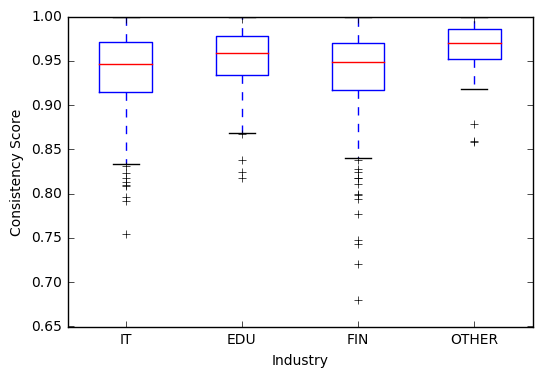

In [61]:
plt.figure()
plt.boxplot(c_score_by_industry)

plt.xlabel('Industry'); plt.ylabel('Consistency Score')
xt = [1,2,3,4]; labels = ['IT', 'EDU', 'FIN', 'OTHER']
plt.xticks(xt, labels)
plt.show(); plt.close()

### Specialized Jobs

In [250]:
se_by_industry

,title,industry,n_post,consistency_score
15069,Software Engineer,Transportation and Storage,5,0.987
15062,Software Engineer,Education,7,0.970
15063,Software Engineer,Financial and Insurance Activities,48,0.952
15060,Software Engineer,Administrative and Support Service Activities,160,0.919
15070,Software Engineer,Wholesale and Retail Trade,62,0.886
15067,Software Engineer,"Professional, Scientific and Technical Activities",85,0.878
15064,Software Engineer,Information and Communications,334,0.861
15065,Software Engineer,Manufacturing,77,0.847


In [231]:
# se_in_fin['top_topics'] = se_in_fin.apply(getTopClusters_GT, axis=1, doc_topic_distr=doc_topic_distr, thres=.4)
# se_in_fin.head()

### Detect "synonym" job titles based on similarity in job posts


### Compare with results from MALLET

In this part, we compare our Python results with the results returned by the LDA from MALLET library implemented by UMASS. It is noteworthy that the MALLET's LDA is trained using __all words__ in job descriptions, not just skill terms as ours. Thus, topics returned by MALLET's LDA are not just skill clusters but also include other topics such as _work conditions & requirements_, _skill-knowledge-ability_ (SKA). We now compare topics assigned to JDs by MALLET's LDA with topics assigned to JDs by our implementation.

#### Topics assigned to JDs by MALLET's LDA

In [ ]:
skill_df = pd.read_csv(DATA_DIR + 'skill_index.csv')
skills = skill_df['skill']
# check if skills contain stop-words
# any(skills == 'etc')

In [ ]:
jd_docs = df['doc']; n_doc = len(jd_docs)
print('# job descriptions in the dataset: %d' %n_doc)

In [104]:
%run -p vs_malletLDA.py

risk management(0.246);project management(0.21);maintenance(0.173)
 

In [ ]:
t0 = time()
tmp = np.apply_along_axis(getTopTopics, 1, mallet_doc_topic, topics=topics)
print('Done after %.1fs' %(time() - t0))

In [ ]:
df['top_topics_by_mallet_lda'] = tmp

In [ ]:
df.to_csv(MALLET_LDA + 'topic_assign.csv', index=False)

### LDA on Job Descriptions w/o skills as vocabulary

+ Build document-term matrix whose each entry $e[d, t]$ is the count of occurrence of term $t$ in document $d$.

In [ ]:
LDA_DIR = RES_DIR + 'lda_all_terms/'

In [ ]:
# XXX: the following only considers unigram, thus it will lose bi-gram and tri-gram skills
count_vec = text_manip.CountVectorizer(stop_words='english')
t0 = time()
doc_term_mat = count_vec.fit_transform(jd_docs)
print('Finished counting term occurrence in %d docs after %.1fs' %(n_doc, (time() - t0)))

In [ ]:
with(open(LDA_DIR + 'doc_term_mat.mtx', 'w')) as f:
    mmwrite(f, doc_term_mat)

In [ ]:
terms = count_vec.get_feature_names()

In [ ]:
# sanity check
first_doc = jd_docs.iat[0]; 
occur_terms = getTermsInDoc(row=0, doc_term_mat=doc_term_mat, vocab=terms)
all(occur_terms[i] in first_doc for i in range(len(occur_terms)))

+ Training LDA:

In [ ]:
n_feat = doc_term_mat.shape[1]
in_train, in_test = mkPartition(n_doc, p=80)

doc_term_mat = doc_term_mat.tocsr()
X_train, X_test = doc_term_mat[in_train, :], doc_term_mat[in_test, :]

In [ ]:
print('# JDs: %d' %n_doc); print('# terms: %d' %n_feat)

In [ ]:
beta = 0.1 # or 200/W
ks  = range(25, 55, 5)

In [ ]:
lda = trainLDA(beta, ks, trainning_set=X_train)

+ Save trained LDA models:

In [ ]:
for k in ks:
    lda_topics = top_words_df(n_top_words=20, model=lda[k], feature_names=terms) 
    lda_topics.to_csv(LDA_DIR + '{}topics.csv'.format(k), index=False)

In [ ]:
# Statistics check

In [13]:
posts = pd.read_csv(DATA_DIR + 'full_job_posts.csv')
print posts.shape
posts.head()

(249386, 17)


,employer_id,job_id,no_of_applications,job_posting_date_history,job_expiry_date_history,job_expiry_year,job_ssoc_code_list,title,no_of_vacancies,job_monthly_min_sal,job_monthly_max_sal,no_of_times_job_posting_reopened,job_posting_status,job_employment_type_list,job_experience_required_years,job_level,employer_name
0,002,JOB-2015-0145758,1.0,2015-01-13,2015-02-12,2015,31275,Architectural Assistant,2,4000.0,6000.0,0,Closed,"Full Time, Permanent",3.0,Manager,HDA Architects
1,002,JOB-2015-0145763,3.0,2015-01-13,2015-02-12,2015,31271,Draftsman,3,3500.0,4500.0,0,Closed,"Full Time, Permanent",3.0,Executive,HDA Architects
2,002,JOB-2015-0195158,2.0,2015-03-24,2015-04-23,2015,31275,Architectural Assistant,2,4000.0,6000.0,0,Closed,"Full Time, Permanent",3.0,Manager,HDA Architects
3,002,JOB-2015-0195159,1.0,2015-03-24,2015-04-23,2015,31271,Draftsman,3,3500.0,4500.0,0,Closed,"Full Time, Permanent",3.0,Executive,HDA Architects
4,002,JOB-2015-0227675,8.0,2015-05-06,2015-06-05,2015,31275,Architectural Assistant,2,4000.0,6000.0,0,Closed,"Full Time, Permanent",3.0,Manager,HDA Architects


In [16]:
jd_df = pd.read_csv('d:/larc_projects/job_analytics/data/raw/jd.csv')
print jd_df.shape
jd_df.head()

(264214, 4)


,job_id,job_description_clob,job_other_requirements_clob,month_year
0,JOB-2014-0000006,"Able to do installation, maintenance &amp; ser...",NaN,Jun-14
1,JOB-2014-0000093,supervise a team of cleaners,No Formal Education-Secondary or equivalent,Jun-14
2,JOB-2014-0000095,Basic housekeeping tasks (manual or with the u...,NaN,Jun-14
3,JOB-2014-0000098,<p>\r\r\n\tHandle incoming and outgoing items ...,NaN,Jun-14
4,JOB-2014-0000101,Conduct maintenance and repair work for ground...,NaN,Jun-14


In [17]:
tmp = pd.merge(posts, jd_df)
tmp = tmp.drop_duplicates()
tmp.shape

(176732, 20)

In [18]:
tmp = tmp.drop_duplicates(['employer_name', 'job_description_clob'])
tmp.shape

(106723, 20)

In [20]:
with(open(DATA_DIR + 'doc_skill.mtx', 'r')) as f:
    doc_skill_mat = mmread(f)

# doc_skill_mat is used in training LDA
doc_skill_mat.shape

### Consistency of Job Posts (Old version)

In [ ]:
def consistencyScore(job_title):
    df = doc_index[doc_index['title'] == job_title]
    # rm outliers: posts with too few
    lb = df['n_skill'].quantile(.25) 
    df = df[(df['n_skill'] >= lb)]
    n_post = df.shape[0]
    posts_of_title = df.sample(n=100) if n_post > 100 else df
        
    sample_size = posts_of_title.shape[0]
    print('Job title {}:'.format(job_title))
    print('\t use a sample of {} posts, each post with at least {} skills...'.format(sample_size, int(lb)))
    
    t0 = time(); 
    res = calScore(job_title, posts_of_title, doc_topic_distr)
    print('\t done after %.1fs' %(time() - t0))
    
    # score = res['sim_score'].median(); score = res['sim_score'].mean()
    score = res['sim_score'].min()
    print('\t consistency score: {}'.format(round(score, 3)))
    return score
    
    #     return res

In [ ]:
JOB_PROF = LDA_DIR + 'job_prof/'

#### Investigate suspicious jobs among the jobs with high consistency score

By _suspicious_, we mean jobs that naturally should not have high consistency score but turn out to be so in data. Looking at the top-50 jobs, we found the following set of suspicious jobs.

{Lecturer Polytechnic, Test Analyst, Retail Associate, Delivery Driver, Administrative Executive, Production Planner}

+ Lecturer, Polytechnic:

In [ ]:
pl_posts = df.query('job_title == "Lecturer, Polytechnic"')
print(pl_posts['employer_name'].unique())
# pl_posts.head(10)

The posts are consistent because they come from just 2 polytechs!

+ Test Analyst:

In [ ]:
ta_posts = df.query('job_title == "Test Analyst"')
ta_posts.head()

### Correlation between consistency score and number of industries

__Note__: the code below can have bugs. Need to obtain for each job title the number of industries where the job title appear.

In [ ]:
cor_df = res.groupby('n_industry')['consistency_score'].mean().round(3)
cor_df = cor_df.to_frame().reset_index()

+ Scatter Plot for the correlation :

In [ ]:
import seaborn as sns

In [ ]:
g = sns.lmplot(data=cor_df, x='n_industry', y='consistency_score', fit_reg=True)

g.set_axis_labels('# industry', 'Consistency score')
g.axes[0,0].set_xlim(0)
g.axes[0,0].set_xticks(range(2,20,2))

g.savefig(RES_DIR + 'fig/cscore_industry_cor.pdf')
g.fig

In [ ]:
# plt.figure()
# plt.plot(cor_df['n_industry'], cor_df['consistency_score'], 'bo')
# plt.xlabel('# industry'); plt.ylabel('Consistency score')

# # add regression line
# x, y = cor_df['n_industry'], cor_df['consistency_score']
# y_hat = np.poly1d(np.polyfit(x, y, 1))(x)
# plt.plot(x, y_hat, '--k')

# plt.show(); plt.close()

##### Previous results

In [ ]:
se_res = consistencyScore('Software Engineer')
rf_res = consistencyScore('Research Fellow')
man_res = consistencyScore('Manager')

dir_res = consistencyScore('Director')
sec_res = consistencyScore('Secretary')
assoc_res = consistencyScore('Associate')

analyst_res = consistencyScore('Analyst')

se_res.to_csv(JOB_PROF + 'se_res.csv', index=False); rf_res.to_csv(JOB_PROF + 'rf_res.csv', index=False)
man_res.to_csv(JOB_PROF + 'man_res.csv', index=False); dir_res.to_csv(JOB_PROF + 'dir_res.csv', index=False)
sec_res.to_csv(JOB_PROF + 'sec_res.csv', index=False); assoc_res.to_csv(JOB_PROF + 'assoc_res.csv', index=False)
analyst_res.to_csv(JOB_PROF + 'analyst_res.csv', index=False)

fm_res = consistencyScore('Facilities Manager'); am_res = consistencyScore('Assistant Manager')
md_res = consistencyScore('Marketing Director'); lm_res = consistencyScore('Logistics Manager')
nurse_res = consistencyScore('Nurse')

In [ ]:
res = [se_res['sim_score'], rf_res['sim_score'], sec_res['sim_score'], 
       man_res['sim_score'], analyst_res['sim_score'], assoc_res['sim_score']]

plt.figure(figsize=(10,5))
plt.boxplot(res)
plt.xlabel('Jobs'); plt.ylabel('Similarity scores')
xt = [1,2,3,4,5,6]; 
labels = ['Software Engineer', 'Research Fellow', 'Secretary', 'Manager', 'Analyst', 'Associate']
plt.xticks(xt, labels)
plt.grid(True)

plt.savefig(LDA_DIR + 'fig/sim_scores2.jpg')
plt.show(); plt.close()

#### Investigate the (suspected) outliers in the box plots

In [ ]:
se_outliers = analyzeOutliers(se_res)
se_outliers.to_csv(JOB_PROF + 'se_outliers.csv', index=False)

man_outliers = analyzeOutliers(man_res)
man_outliers.to_csv(JOB_PROF + 'man_outliers.csv', index=False)

assoc_outliers = analyzeOutliers(assoc_res)
assoc_outliers.to_csv(JOB_PROF + 'assoc_outliers.csv', index=False)

analyst_outliers = analyzeOutliers(analyst_res)
analyst_outliers.to_csv(JOB_PROF + 'analyst_outliers.csv', index=False)

se_outliers['sim_score'].describe()

man_outliers['sim_score'].describe()